In [1]:
#imports
import torch
import clip
from PIL import Image
import json
import glob
import matplotlib.pyplot as plt
import random
import numpy as np

random.seed(37)
torch.manual_seed(37)
np.random.seed(37)

In [2]:
#open the json file for annotations
f = open('datasets/flickr30k/dataset_flickr30k.json')
data = json.load(f)

In [3]:
caps = [x['sentences'] for x in data['images'] if x.get('split') == 'test']

caption_ids = []
for x in data['images']:
    if x.get('split') == 'test':
        for i in range(len(x.get('sentences'))):
            caption_ids.append(int(x['filename'][:-4]))
            
captions = []
for x in caps:
    for y in x:
        captions.append(y)
    
captions = [x.get('raw') for x in captions]

# 1 caption is too long, this shortens it to prevent errors
string = 'Two boys are looking upwards with their arms streteched to the sky, the boy on the left is wearing a blue vest jacket with a gray shirt, black jogging pants and a hat, and the boy on the right is wearing a silver vest jacket, with blue long-sleeved undershirt, gray pants, black tennis shoes and has black short hair and glasses.'
captions[3905] = string

In [11]:
image_RA1 = []
image_RA5 = []
image_RA10 = []
text_RA1 = []
text_RA5 = []
text_RA10 = []
for model in labels:
    print("testing model:", model)
    #load CLIP model
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load(model, device=device)
    model.eval()

    # load images
    images = []
    image_ids = []
    i = 0
    for filename in glob.glob('datasets/flickr30k/test/*.jpg'):
        image_ids.append(int(filename[24:-4]))
        im=preprocess(Image.open(filename))
        images.append(im)
        i+=1
        if (i%250) == 0:
            print(i,"/1000", end='\r')
    image_ids = torch.Tensor(image_ids)
    print("")
    
    #encode images
    test_images = torch.Tensor().to(device)
    with torch.no_grad():
        print("0 /",len(images), end='\r')
        for i in range(0, len(images), 64):
            ims=model.encode_image(torch.stack(images[i:i+64]).to(device))
            test_images = torch.cat((test_images, ims), 0)
            if (i%128) == 0:
                print(i,"/",len(images), end='\r')

        print("1000 /",len(images), end='\r')

    test_images /= test_images.norm(dim=-1, keepdim=True)
    encoded_images = test_images
    print("")

    # encode captions
    text = clip.tokenize(captions).to(device)
    test_captions = torch.Tensor().to(device)
    with torch.no_grad():
        print("0 / 5000", end='\r')
        for i in range(0, len(text), 128):
            ts = model.encode_text(text[i:i+128])
            test_captions = torch.cat((test_captions, ts), 0)
            if (i%512) == 0:
                print(i,"/",len(text), end='\r')

        print("5000 / 5000", end='\r')

    text_features = test_captions
    text_features /= text_features.norm(dim=-1, keepdim=True)
    encoded_captions = list(zip(caption_ids, text_features))
    
    # get recall scores for current model(/epoch) (text to image)
    recall_1 = []
    recall_5 = []
    recall_10 = []
    for image_id, text_feature in encoded_captions: 
        similarity = (100.0 * text_feature @ encoded_images.T).softmax(dim=-1)
        
        values, indices = similarity.topk(1)
        recall_1.append(image_id in image_ids[indices])
        
        values, indices = similarity.topk(5)
        recall_5.append(image_id in image_ids[indices])
    
        values, indices = similarity.topk(10)
        recall_10.append(image_id in image_ids[indices])

    recall_1 = torch.Tensor(recall_1)
    image_RA1.append(recall_1.mean())
    
    recall_5 = torch.Tensor(recall_5)
    image_RA5.append(recall_5.mean())
    
    recall_10 = torch.Tensor(recall_10)
    image_RA10.append(recall_10.mean())

    # get recall scores for current model(/epoch) (image to text)
    recall_1 = []
    recall_5 = []
    recall_10 = []
    for i, image in enumerate(encoded_images): 
        similarity = (100.0 * image @ text_features.T).softmax(dim=-1)
        
        values, indices = similarity.topk(1)
        im_ids = []
        for indice in indices:
            im_ids.append(caption_ids[indice])
        recall_1.append(image_ids[i] in im_ids)
        
        values, indices = similarity.topk(5)
        im_ids = []
        for indice in indices:
            im_ids.append(caption_ids[indice])
        recall_5.append(image_ids[i] in im_ids)
        
        values, indices = similarity.topk(10)
        im_ids = []
        for indice in indices:
            im_ids.append(caption_ids[indice])
        recall_10.append(image_ids[i] in im_ids)

    recall_1 = torch.Tensor(recall_1)
    text_RA1.append(recall_1.mean())
    
    recall_5 = torch.Tensor(recall_5)
    text_RA5.append(recall_5.mean())
    
    recall_10 = torch.Tensor(recall_10)
    text_RA10.append(recall_10.mean())
    print("")

testing model: RN50
1000 /1000
1000 / 1000/ 1000 / 1000 / 1000 / 1000 / 1000
5000 / 5000
testing model: RN101
1000 /1000
1000 / 1000
5000 / 5000
testing model: RN50x4
1000 /1000
1000 / 1000
5000 / 5000
testing model: RN50x16
1000 /1000
1000 / 1000
5000 / 5000
testing model: ViT-B/32
1000 /1000
1000 / 1000
5000 / 5000
testing model: ViT-B/16
1000 /1000
1000 / 1000
5000 / 5000
testing model: ViT-L/14
1000 /1000
1000 / 1000
5000 / 5000


In [7]:
labels = ['RN50','RN101','RN50x4','RN50x16','ViT-B/32','ViT-B/16','ViT-L/14']
x = [1,2,3,4,5,6,7]

In [18]:
image_RA10

[tensor(0.9002),
 tensor(0.8854),
 tensor(0.9020),
 tensor(0.9180),
 tensor(0.9006),
 tensor(0.9190),
 tensor(0.9208)]

In [7]:
"""
image_RA1.insert(4, torch.tensor(0.6906))
image_RA5.insert(4, torch.tensor(0.8992))
image_RA10.insert(4, torch.tensor(0.9430))
text_RA1.insert(4, torch.tensor(0.8690))
text_RA5.insert(4, torch.tensor(0.9820))
text_RA10.insert(4, torch.tensor(0.9920))
"""

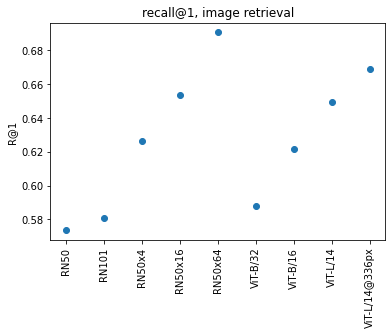

In [10]:
plt.scatter(x, image_RA1)
plt.xticks(x, labels, rotation='vertical')
plt.title("recall@1, image retrieval")
plt.ylabel('R@1')
plt.show()

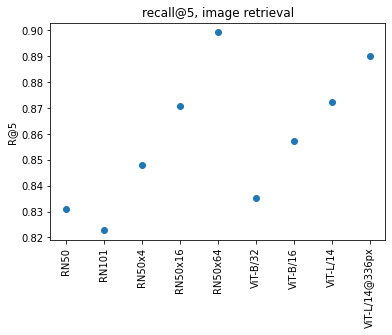

In [36]:
plt.scatter(x, image_RA5)
plt.xticks(x, labels, rotation='vertical')
plt.title("recall@5, image retrieval")
plt.ylabel('R@5')
plt.show()

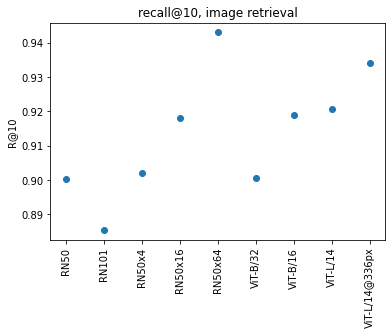

In [37]:
plt.scatter(x, image_RA10)
plt.xticks(x, labels, rotation='vertical')
plt.title("recall@10, image retrieval")
plt.ylabel('R@10')
plt.show()

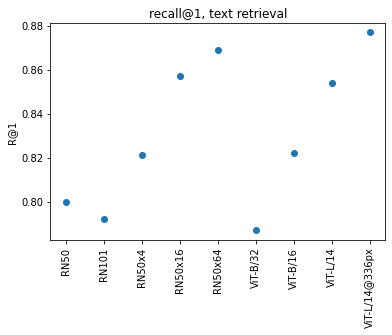

In [38]:
plt.scatter(x, text_RA1)
plt.xticks(x, labels, rotation='vertical')
plt.title("recall@1, text retrieval")
plt.ylabel('R@1')
plt.show()

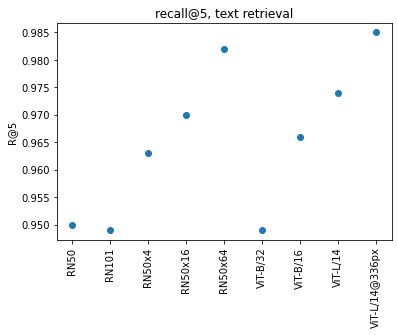

In [39]:
plt.scatter(x, text_RA5)
plt.xticks(x, labels, rotation='vertical')
plt.title("recall@5, text retrieval")
plt.ylabel('R@5')
plt.show()

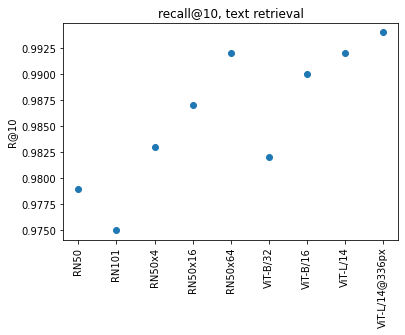

In [40]:
plt.scatter(x, text_RA10)
plt.xticks(x, labels, rotation='vertical')
plt.title("recall@10, text retrieval")
plt.ylabel('R@10')
plt.show()